# Evaluation Analysis of Developed Methodology for Trust Estimation

## Libraries

In [1]:
import re
import os
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.ticker import FuncFormatter
from matplotlib.patches import FancyArrowPatch
from scipy import stats
from typing import Tuple

# get the current script's directory
current_directory = os.path.dirname(os.path.abspath(__file__)) if "__file__" in locals() else os.getcwd()
# get the parent directory
parent_directory = os.path.dirname(current_directory)
# add the parent directory to the sys.path
sys.path.append(parent_directory)

from utils import constants

from optimization import functions

from trusts.model_dynamics import TrustDistribution
from trusts.mle_optimization import MLEOptimization

In [2]:
pd.set_option("display.max_columns",
              None)

## Functions for Plotting

In [3]:
def sorting_key(filename: str) -> list:
    # define a sorting key function using regular expressions
    
    # extract all numeric parts
    parts = re.findall(r'\d+', filename)
    return [int(part) for part in parts]

In [4]:
def plot_beta_distribution(axi: plt,
                           distribution_object: TrustDistribution,
                           trust_label: float,
                           experiment_count: int,
                           title_label_name: str,
                           is_save_fig: bool = False) -> None:
    
    mean_value = distribution_object.get_beta_distribution_mean()
    
    label1 = "Human Trust Model Histogram"
    label2 = "Probability Density Function"
    label3 = "Trust Estimation [Mean Value]"
    label4 = "Trust Label [Co-Worker Survey]"
    label5 = f"Absolute Error (%) = {100 * abs(mean_value - trust_label):.1f}"
    
    title_label = f"(\u03B1\u2080={distribution_object.initial_alpha:.1f}; \u03B2\u2080={distribution_object.initial_beta:.1f}; \u03B3={distribution_object.gamma:.4f}; \u03B5={distribution_object.epsilon_reward:.4f}; \u03C9\u02E2={distribution_object.w_success:.4f}; \u03C9\u1da0={distribution_object.w_failure:.4f})"
    
    # generate random samples from the beta distribution
    sample_size = 2000
    samples = stats.beta.rvs(distribution_object.alpha,
                             distribution_object.beta,
                             size=sample_size)

    # plot the histogram of the generated samples
    hist1 = axi.hist(samples,
                     bins=30,
                     density=True,
                     alpha=0.5,
                     color="darkorange",
                     label=label1)

    # plot the probability density function (PDF) of the beta distribution
    x = np.linspace(0, 1, 100)
    pdf = stats.beta.pdf(x,
                         distribution_object.alpha,
                         distribution_object.beta)
    plot1 = axi.plot(x,
                     pdf,
                     color="darkred",
                     linestyle="-",
                     linewidth=2,
                     label=label2)

    # plot the mean value as a horizontal line
    line1 = axi.axvline(x=mean_value,
                        color="darkgreen",
                        linestyle="--",
                        linewidth=2,
                        label=label3)
    
    line2 = axi.axvline(x=trust_label,
                        color="darkblue",
                        linestyle="--",
                        linewidth=2,
                        label=label4)
    
    # check the proximity of mean_value and trust_label
    if mean_value - trust_label < 0.04:

        # if close, adjust the position of the text based on the sign of the difference
        if mean_value > trust_label:
            axi.text(mean_value + 0.008,
                     0.4,
                     f"Trust Estimation: % {100 * mean_value:.1f}",
                     color="darkgreen",
                     fontsize=14,
                     fontweight="bold",
                     rotation=90,
                     ha="left")
        else:
            axi.text(mean_value - 0.004,
                     0.4,
                     f"Trust Estimation: % {100 * mean_value:.1f}",
                     color="darkgreen",
                     fontsize=14,
                     fontweight="bold",
                     rotation=90,
                     ha="right")
    else:
        # adjust the position based on the sign of the difference
        if mean_value > trust_label:
            axi.text(mean_value - 0.004,
                     0.4,
                     f"Trust Estimation: % {100 * mean_value:.1f}",
                     color="darkgreen",
                     fontsize=14,
                     fontweight="bold",
                     rotation=90,
                     ha="right")
        else:
            axi.text(mean_value + 0.008,
                     0.4,
                     f"Trust Estimation: % {100 * mean_value:.1f}",
                     color="darkgreen",
                     fontsize=14,
                     fontweight="bold",
                     rotation=90,
                     ha="left")
    
    axi.text(trust_label - 0.025,
             0.4,
             f"Trust Label: % {100 * trust_label:.1f}",
             color="darkblue",
             fontsize=14,
             fontweight="bold",
             rotation=90,
             ha="left")
    
    # create an arrow between mean_value and trust_label
    arrow_params = {
        "arrowstyle": "<|-|>",
        "mutation_scale": 15,
        "color": "black",
        "linewidth": 2,
        "label": label5
    }
    axi.annotate("",
                 xy=(mean_value, 0.07),
                 xytext=(trust_label, 0.07),
                 arrowprops=arrow_params)
    arrow_legend = FancyArrowPatch((0, 0),
                                   (1, 0),
                                   **arrow_params)
    
    if mean_value <= 0.5:
        anchor_posx, anchor_posy = 1.0, 1.0
    else:
        anchor_posx, anchor_posy = 0.53, 1.0
    
    legend = axi.legend(handles=[hist1[2][0], plot1[0], line1, line2, arrow_legend],
                        labels=[label1, label2, label3, label4, label5],
                        loc="upper right",
                        bbox_to_anchor=(anchor_posx, anchor_posy),
                        fancybox=True,
                        shadow=True,
                        fontsize=12,
                        title=f"{title_label_name} Experiment #{experiment_count}",
                        title_fontsize="12")
#     legend.get_title().set_fontweight("bold")
    
    axi.set_title(title_label, fontsize=14)
    axi.set_xlabel(f"Probabilistic Trust Estimation - Beta Distribution (\u03B1={distribution_object.alpha:.1f}; \u03B2={distribution_object.beta:.1f})", fontsize=14)
    axi.set_ylabel("Probability Density Function (pdf)", fontsize=14)
    axi.grid()

    if is_save_fig:
        plt.savefig(f"{title_label_name}_experiment_{experiment_count}_trust_distribution.png", dpi=600, bbox_inches="tight")
    
    plt.show()

In [5]:
def run_through_trajectory(df: pd.DataFrame,
                           column_names: list,
                           distribution_object: TrustDistribution) -> Tuple[pd.DataFrame,
                                                                            TrustDistribution]:
    
    # create a column to store estimated trust values; initialize it to zero as a default value
    for column in column_names[:-1]:
        df[column] = 0.0
    
    reward_array = df["Reward"].to_numpy()
    
    # update distribution parameters (alpha and beta) with current success and failure weights
    for idx, reward in enumerate(reward_array):
        distribution_object.update_parameters(performance=reward)
        
        # store all important parameters in the dataframe
        df.at[idx, column_names[0]] = distribution_object.alpha
        df.at[idx, column_names[1]] = distribution_object.beta
        df.at[idx, column_names[2]] = distribution_object.initial_alpha
        df.at[idx, column_names[3]] = distribution_object.initial_beta
        df.at[idx, column_names[4]] = distribution_object.w_success
        df.at[idx, column_names[5]] = distribution_object.w_failure
        df.at[idx, column_names[6]] = distribution_object.gamma
        df.at[idx, column_names[7]] = distribution_object.epsilon_reward
        
        # calculate and store estimated trust value only after the reward is obtained
        trust_estimation = distribution_object.get_beta_distribution_mean()
        df.at[idx, column_names[8]] = trust_estimation
    
    return df, distribution_object

## Initialization

In [6]:
configs = functions.setup_config(device="cpu")

Current Time:  Mar_05_2024-12_01_56


## Create Beta Distribution Object to Resembe Trust

In [7]:
trust_obj = TrustDistribution(initial_alpha=configs.initial_alpha,
                              initial_beta=configs.initial_beta,
                              gamma=configs.gamma,
                              initial_w_success=configs.initial_w_success,
                              initial_w_failure=configs.initial_w_failure,
                              epsilon_reward=configs.epsilon_reward)

## Read Robot Experiment Outputs

In [8]:
_, results_path = functions.get_directories(parent_directory=parent_directory,
                                            data_folder_name="")
experiments_folder_path = os.path.join(results_path,
                                       "experiments")

In [9]:
# human-in-the-loop stage experiments and results
hil_data_folder_path = os.path.join(experiments_folder_path,
                                    constants.HIL_EXPERIMENT_FOLDER)
if os.path.exists(hil_data_folder_path):
    hil_excel_files = os.listdir(hil_data_folder_path)
else:
    print("NOTE: HIL experiments are not saved @: ", hil_data_folder_path)

# sort the file list using the custom sorting key
hil_excel_files = sorted(hil_excel_files,
                         key=sorting_key)

In [10]:
# inference stage experiments and results
inference_data_folder_path = os.path.join(experiments_folder_path,
                                    constants.INFERENCE_EXPERIMENT_FOLDER)
if os.path.exists(inference_data_folder_path):
    inference_excel_files = os.listdir(inference_data_folder_path)
else:
    print("NOTE: Inference experiments are not saved @: ", inference_data_folder_path)

# sort the file list using the custom sorting key
inference_excel_files = sorted(inference_excel_files,
                               key=sorting_key)

## Read Human Trust Measurement Labels

In [11]:
hil_trust_labels_list = []
for hil_file_name in hil_excel_files:
    trust_match = re.search(r"trust_(\d+)",
                            hil_file_name)
    if trust_match:
        hil_trust_labels_list.append(int(trust_match.group(1)))

In [12]:
inference_trust_labels_list = []
for inference_file_name in inference_excel_files:
    trust_match = re.search(r"trust_(\d+)",
                            inference_file_name)
    if trust_match:
        inference_trust_labels_list.append(int(trust_match.group(1)))

## Define Constant Parameter List

In [13]:
# Do Not Change Order
prior_columns = ["TimeStep",
                 "StateNorm1", "StateNorm2", "StateNorm3",
                 "Reward"]
column_names = ["Alpha", "Beta",
                "Alpha0", "Beta0",
                "SuccessWeight", "FailureWeight",
                "Gamma", "EpsilonReward",
                "TrustEstimation", "TrustLabel"]

## Run Through Human-in-the-Loop (HIL) Stage (3)

C:\ProgramData\anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


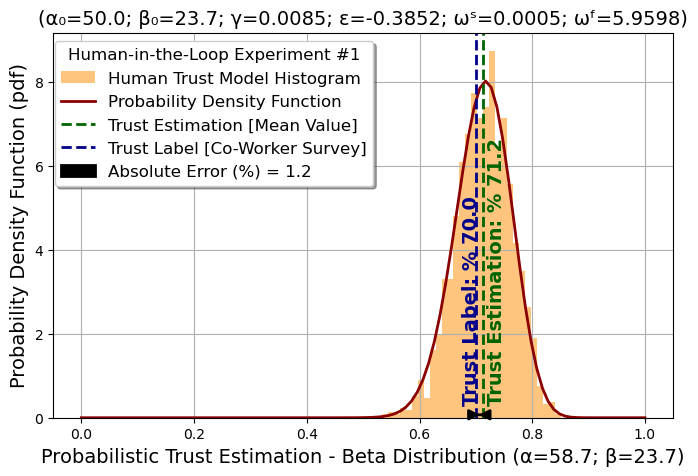

C:\ProgramData\anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


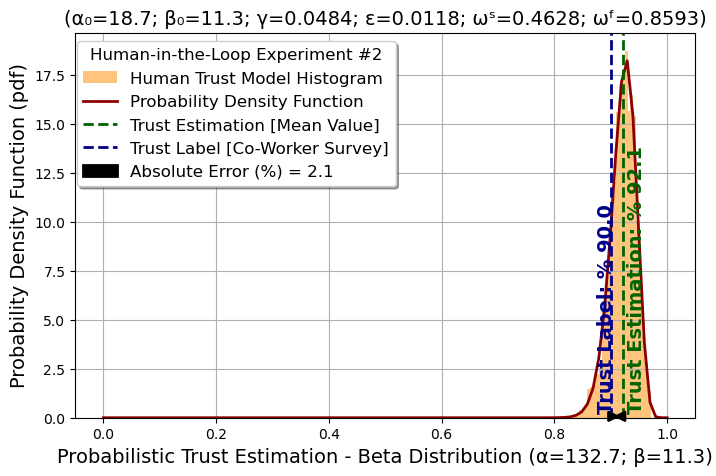

C:\ProgramData\anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,
c:\users\24989903\research-uts\codes\learning-trust-behavior\src\trusts\mle_optimization.py:70: RuntimeWarning: divide by zero encountered in log
  nll = -np.log(beta_distribution.pdf(trust_label,


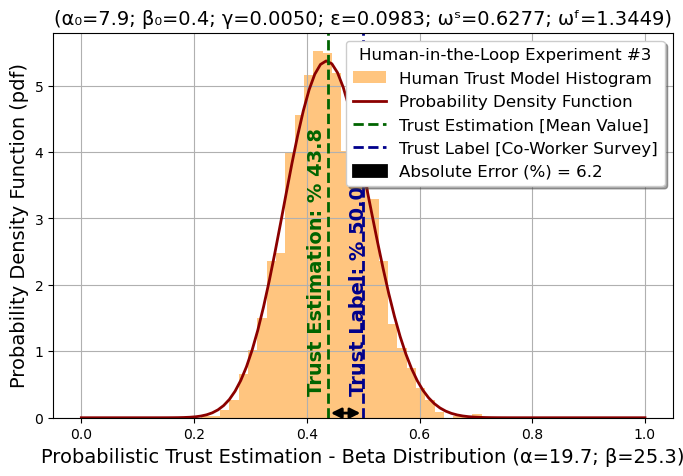

C:\ProgramData\anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


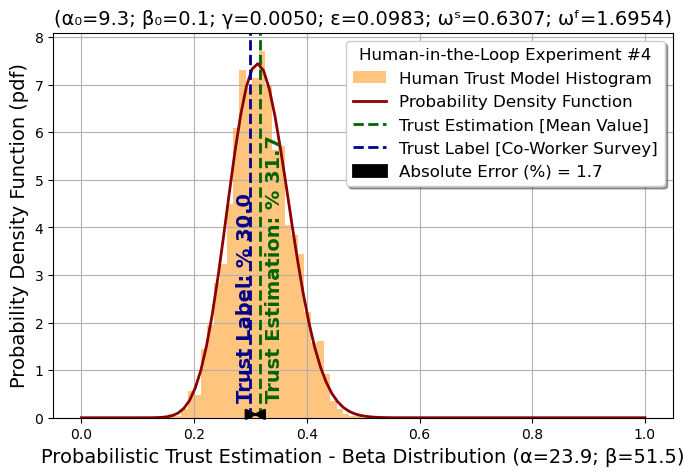

C:\ProgramData\anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


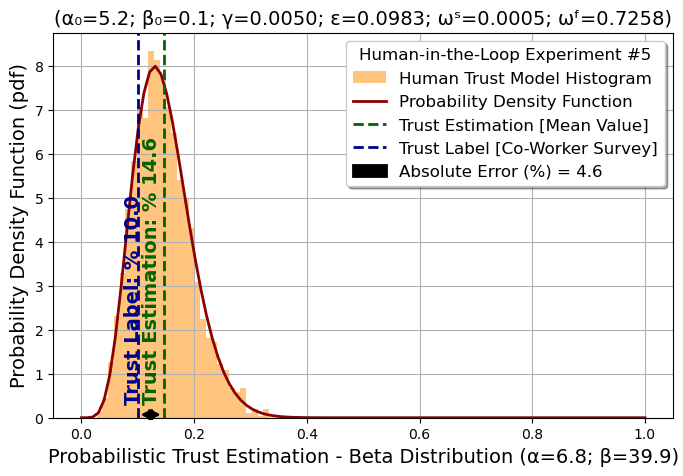

C:\ProgramData\anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,
c:\users\24989903\research-uts\codes\learning-trust-behavior\src\trusts\mle_optimization.py:70: RuntimeWarning: divide by zero encountered in log
  nll = -np.log(beta_distribution.pdf(trust_label,


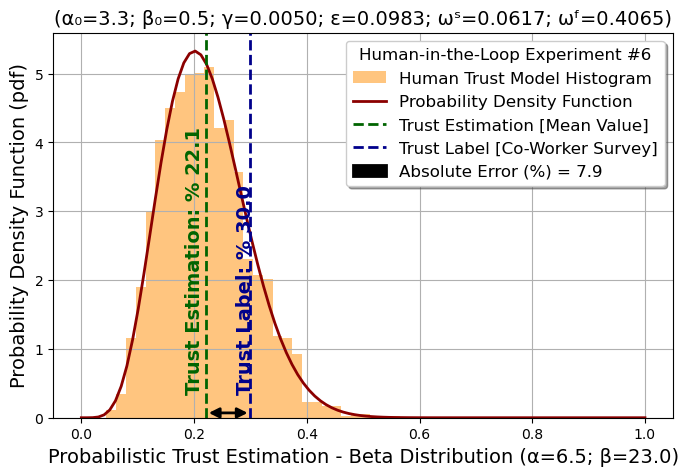

C:\ProgramData\anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


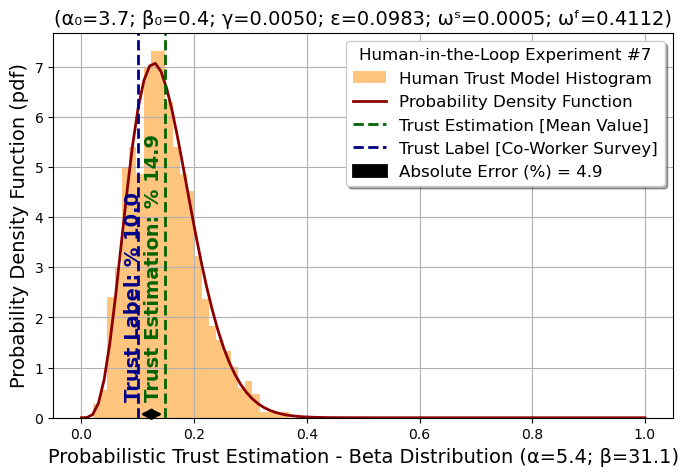

C:\ProgramData\anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


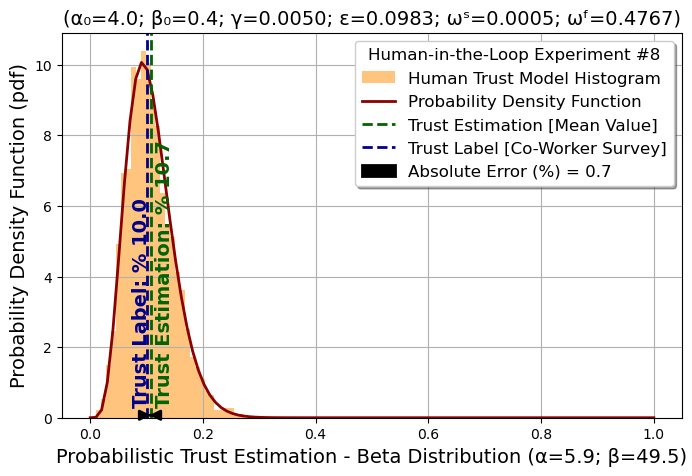

C:\ProgramData\anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,
c:\users\24989903\research-uts\codes\learning-trust-behavior\src\trusts\mle_optimization.py:70: RuntimeWarning: divide by zero encountered in log
  nll = -np.log(beta_distribution.pdf(trust_label,


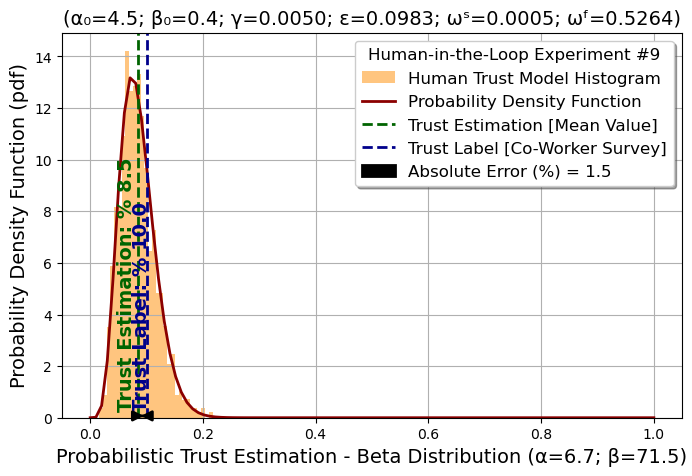

C:\ProgramData\anaconda3\lib\site-packages\scipy\optimize\_differentialevolution.py:382: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  with DifferentialEvolutionSolver(func, bounds, args=args,


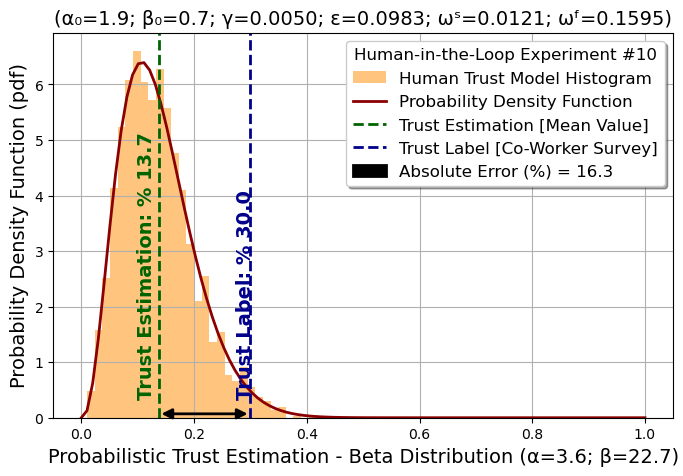

In [14]:
# in human-in-the-loop stage, the following will be updated:
# alpha, beta, alpha_0, beta_0, w_success, w_failure, gamma, eplison_reward
HIL_df = pd.DataFrame(columns=["Experiment"] + prior_columns + column_names)

initial_alpha = 0.5
initial_beta = 0.5
w_success = 0.2
w_failure = 0.2
gamma = 0.1
epsilon_reward = 0.1

for idx, hil_excel in enumerate(hil_excel_files):
    hil_df = pd.read_excel(os.path.join(hil_data_folder_path,
                                        hil_excel))
    
    # measured trust value of the particular experiment (measured at the end of the experiment)
    trust_label = hil_trust_labels_list[idx]
    true_trust = trust_label / 100 # from percentage to range [0, 1]
    
    # store measured trust
    hil_df[column_names[9]] = true_trust
    
    # save referring index of the experiment
    hil_df["Experiment"] = idx + 1
    
    # collect all dataframes for validation
    if len(HIL_df) == 0: HIL_df = hil_df
    else: HIL_df = pd.concat([HIL_df, hil_df],
                             axis=0,
                             ignore_index=True)
    del hil_df
    
    # optimization object for maximum likelihood estimation (MLE)
    mle_obj = MLEOptimization(hil_experiment_data=HIL_df,
                              seed=constants.RANDOM_SEED)
    
    # run optimization
    trust_obj, initial_alpha, initial_beta, w_success, w_failure, gamma, epsilon_reward = mle_obj.fit([initial_alpha,
                                                                                                       initial_beta,
                                                                                                       w_success,
                                                                                                       w_failure,
                                                                                                       gamma,
                                                                                                       epsilon_reward])

    # store important data related to the plotting of the distribution
    HIL_df.loc[HIL_df["Experiment"] == idx + 1, column_names[0]] = trust_obj.alpha
    HIL_df.loc[HIL_df["Experiment"] == idx + 1, column_names[1]] = trust_obj.beta
    HIL_df.loc[HIL_df["Experiment"] == idx + 1, column_names[2]] = trust_obj.initial_alpha
    HIL_df.loc[HIL_df["Experiment"] == idx + 1, column_names[3]] = trust_obj.initial_beta
    HIL_df.loc[HIL_df["Experiment"] == idx + 1, column_names[4]] = trust_obj.w_success
    HIL_df.loc[HIL_df["Experiment"] == idx + 1, column_names[5]] = trust_obj.w_failure
    HIL_df.loc[HIL_df["Experiment"] == idx + 1, column_names[6]] = trust_obj.gamma
    HIL_df.loc[HIL_df["Experiment"] == idx + 1, column_names[7]] = trust_obj.epsilon_reward
    
    # plot estimation, label, error in the trust distribution
    fig, ax = plt.subplots(1, 1,
                           figsize=(8, 5))
    plot_beta_distribution(axi=ax,
                           distribution_object=trust_obj,
                           trust_label=true_trust,
                           experiment_count=idx + 1,
                           title_label_name="Human-in-the-Loop",
                           is_save_fig=True)

In [15]:
HIL_df

,TimeStep,StateNorm1,StateNorm2,StateNorm3,Reward,TrustLabel,Experiment,Alpha,Beta,Alpha0,Beta0,SuccessWeight,FailureWeight,Gamma,EpsilonReward
0,1,0.278327,0.663454,0.350482,0.084249,0.7,1,58.705262,23.724975,50.000000,23.724975,0.000500,5.959780,0.008481,-0.385232
1,2,0.378778,0.606984,0.431282,0.098223,0.7,1,58.705262,23.724975,50.000000,23.724975,0.000500,5.959780,0.008481,-0.385232
2,3,0.379403,0.597494,0.422197,0.111344,0.7,1,58.705262,23.724975,50.000000,23.724975,0.000500,5.959780,0.008481,-0.385232
3,4,0.370923,0.587694,0.415961,0.126263,0.7,1,58.705262,23.724975,50.000000,23.724975,0.000500,5.959780,0.008481,-0.385232
4,5,0.359647,0.576191,0.410865,0.143303,0.7,1,58.705262,23.724975,50.000000,23.724975,0.000500,5.959780,0.008481,-0.385232
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,16,0.226689,0.133116,0.165072,0.448209,0.3,10,3.601348,22.673295,1.887963,0.652891,0.012129,0.159466,0.005000,0.098270
196,17,0.229380,0.131001,0.162676,0.448294,0.3,10,3.601348,22.673295,1.887963,0.652891,0.012129,0.159466,0.005000,0.098270
197,18,0.231157,0.129648,0.161093,0.448349,0.3,10,3.601348,22.673295,1.887963,0.652891,0.012129,0.159466,0.005000,0.098270
198,19,0.232309,0.128790,0.160067,0.448341,0.3,10,3.601348,22.673295,1.887963,0.652891,0.012129,0.159466,0.005000,0.098270


In [16]:
HIL_df.to_excel("HIL_stage_experiment_results.xlsx",
                index=False)

## Run Through Inference Stage (4) After Tuning Beta Distribution Parameters

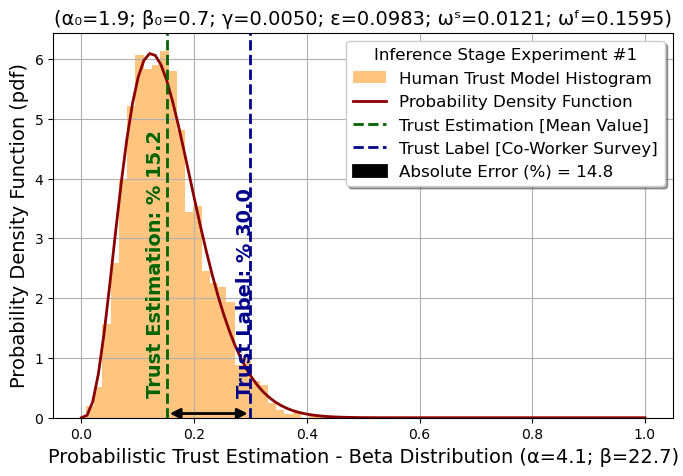

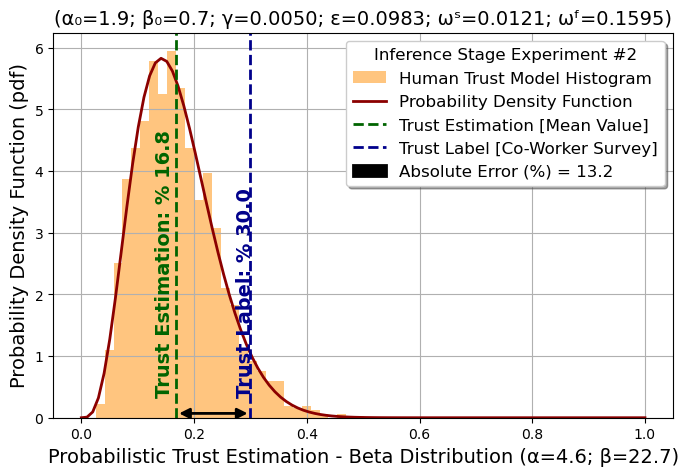

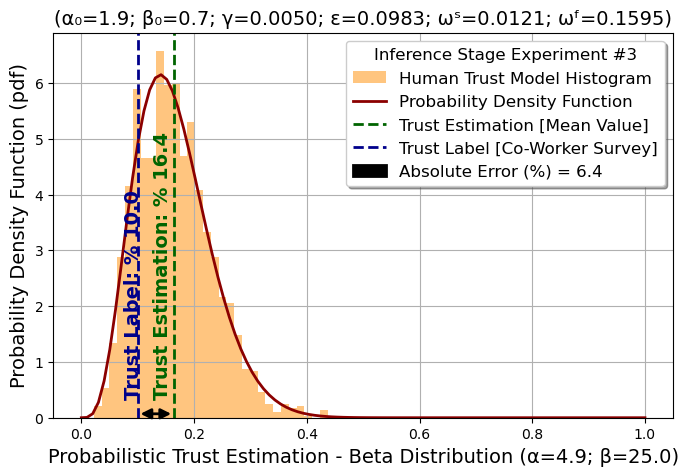

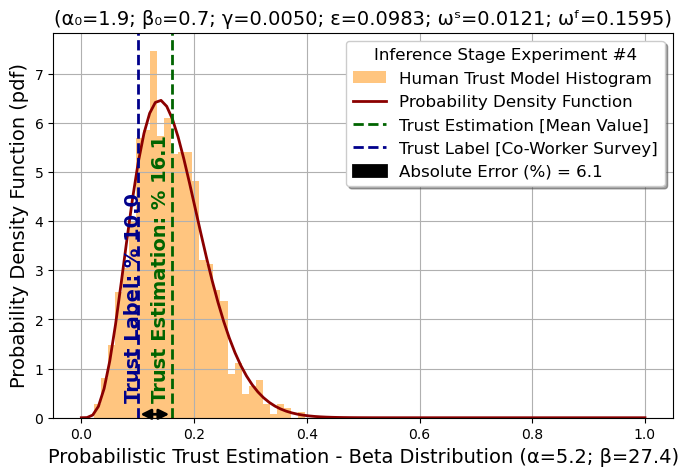

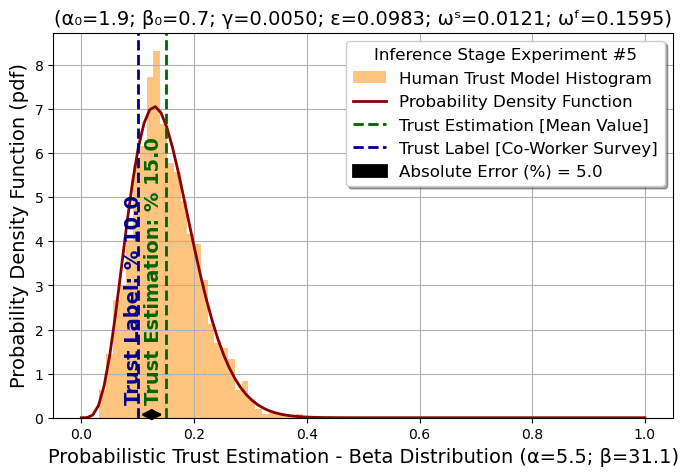

In [17]:
# in human-in-the-loop stage, the following will be constant:
# alpha_0, beta_0, w_success, w_failure, gamma, epsilon_reward
INFERENCE_df = pd.DataFrame(columns=["Experiment"] + prior_columns + column_names)

for idx, inference_excel in enumerate(inference_excel_files):
    inference_df = pd.read_excel(os.path.join(inference_data_folder_path,
                                              inference_excel))
    
    # measured trust value of the particular experiment (measured at the end of the experiment)
    trust_label = inference_trust_labels_list[idx]
    true_trust = trust_label / 100 # from percentage to range [0, 1]
    
    # store measured trust
    inference_df[column_names[9]] = true_trust
    
    # save referring index of the experiment
    inference_df["Experiment"] = idx + 1
    
    # by running the following, only alpha and beta parameters will be updated
    inference_df, trust_obj = run_through_trajectory(df=inference_df,
                                                     column_names=column_names,
                                                     distribution_object=trust_obj)
    
    # collect all dataframes
    if len(inference_df) == 0:
        INFERENCE_df = inference_df
    else:
        INFERENCE_df = pd.concat([INFERENCE_df, inference_df], axis=0, ignore_index=True)
    
    # plot estimation, label, error in the trust distribution
    fig, ax = plt.subplots(1, 1,
                           figsize=(8, 5))
    plot_beta_distribution(axi=ax,
                           distribution_object=trust_obj,
                           trust_label=true_trust,
                           experiment_count=idx + 1,
                           title_label_name="Inference Stage",
                           is_save_fig=True)

In [18]:
INFERENCE_df

,Experiment,TimeStep,StateNorm1,StateNorm2,StateNorm3,Reward,Alpha,Beta,Alpha0,Beta0,SuccessWeight,FailureWeight,Gamma,EpsilonReward,TrustEstimation,TrustLabel
0,1,1,0.175484,0.663454,0.350482,0.115040,3.620722,22.673295,1.887963,0.652891,0.012129,0.159466,0.005,0.09827,0.137701,0.3
1,1,2,0.340628,0.576167,0.426812,0.142809,3.640551,22.673295,1.887963,0.652891,0.012129,0.159466,0.005,0.09827,0.138351,0.3
2,1,3,0.342571,0.562095,0.410751,0.162741,3.660719,22.673295,1.887963,0.652891,0.012129,0.159466,0.005,0.09827,0.139011,0.3
3,1,4,0.329712,0.546856,0.400674,0.185648,3.681265,22.673295,1.887963,0.652891,0.012129,0.159466,0.005,0.09827,0.139682,0.3
4,1,5,0.312151,0.528676,0.392526,0.211976,3.702231,22.673295,1.887963,0.652891,0.012129,0.159466,0.005,0.09827,0.140366,0.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5,16,0.348435,0.564925,0.406291,0.159794,5.359499,31.124042,1.887963,0.652891,0.012129,0.159466,0.005,0.09827,0.146902,0.1
96,5,17,0.333147,0.549635,0.400350,0.181958,5.388494,31.124042,1.887963,0.652891,0.012129,0.159466,0.005,0.09827,0.147579,0.1
97,5,18,0.315372,0.531767,0.393393,0.207640,5.417944,31.124042,1.887963,0.652891,0.012129,0.159466,0.005,0.09827,0.148266,0.1
98,5,19,0.294724,0.510852,0.385210,0.237009,5.447896,31.124042,1.887963,0.652891,0.012129,0.159466,0.005,0.09827,0.148964,0.1


In [19]:
INFERENCE_df.to_excel("INFERENCE_stage_experiment_results.xlsx",
                      index=False)

## Optimization Process Plots from Human-in-the-Loop (HIL) Stage (3)

In [20]:
hil_results_df = pd.read_excel("HIL_stage_experiment_results.xlsx")

In [21]:
last_step_hil_results_df = hil_results_df[hil_results_df["Experiment"] != hil_results_df["Experiment"].shift(-1)]
last_step_hil_results_df

,TimeStep,StateNorm1,StateNorm2,StateNorm3,Reward,TrustLabel,Experiment,Alpha,Beta,Alpha0,Beta0,SuccessWeight,FailureWeight,Gamma,EpsilonReward
19,20,0.186125,0.173792,0.202890,0.444389,0.7,1,58.705262,23.724975,50.000000,23.724975,0.000500,5.959780,0.008481,-0.385232
39,20,0.232908,0.128349,0.159531,0.448326,0.9,2,132.728582,11.329679,18.670985,11.329679,0.462837,0.859327,0.048353,0.011828
59,20,0.344717,0.561213,0.404849,0.165189,0.5,3,19.731954,25.338977,7.899742,0.375445,0.627666,1.344934,0.005000,0.098270
79,20,0.212631,0.424015,0.350156,0.340383,0.3,4,23.937728,51.488677,9.300637,0.100000,0.630677,1.695371,0.005000,0.098270
99,20,0.398616,0.614782,0.425691,0.086538,0.1,5,6.827264,39.930382,5.234109,0.100000,0.000500,0.725824,0.005000,0.098270
119,20,0.232536,0.128623,0.159864,0.448335,0.3,6,6.532290,23.003031,3.295501,0.475221,0.061746,0.406506,0.005000,0.098270
139,20,0.315692,0.532090,0.393518,0.207178,0.1,7,5.438784,31.115400,3.675381,0.433225,0.000500,0.411233,0.005000,0.098270
159,20,0.439702,0.660264,0.455321,0.009842,0.1,8,5.949588,49.488721,4.001500,0.350638,0.000500,0.476718,0.005000,0.098270
179,20,0.421019,0.636925,0.434372,0.051715,0.1,9,6.650993,71.524955,4.474488,0.363958,0.000500,0.526394,0.005000,0.098270
199,20,0.233045,0.128250,0.159409,0.448322,0.3,10,3.601348,22.673295,1.887963,0.652891,0.012129,0.159466,0.005000,0.098270


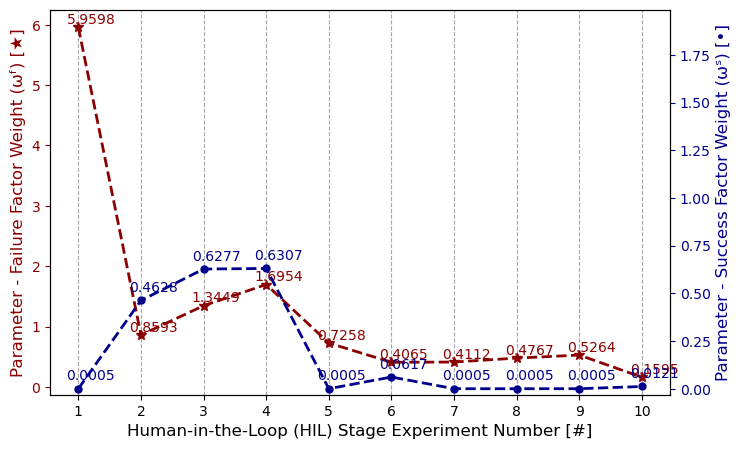

In [22]:
experiment_column = "Experiment"
success_weight_column = "SuccessWeight"
failure_weight_column = "FailureWeight"

fig, ax1 = plt.subplots(1, 1,
                        figsize=(8, 5))

failure_scatter = ax1.plot(last_step_hil_results_df[experiment_column],
                           last_step_hil_results_df[failure_weight_column],
                           color="darkred",
                           marker="*",
                           markersize=7,
                           linestyle="--",
                           linewidth=2,
                           label="Failure Weight (\u03C9\u1da0)")

# ax1.set_title("Parameter Optimization with Maximum Likelihood Estimation (MLE)", fontsize=12)
ax1.set_xlabel("Human-in-the-Loop (HIL) Stage Experiment Number [#]",
               fontsize=12)
ax1.set_ylabel(f"Parameter - Failure Factor Weight (\u03C9\u1da0) [★]",
               color="darkred",
               fontsize=12)
ax1.tick_params("y",
                colors="darkred")

success_scatter = ax1.twinx()

success_scatter.plot(last_step_hil_results_df[experiment_column],
                     last_step_hil_results_df[success_weight_column],
                     color="darkblue",
                     marker="o",
                     markersize=5,
                     linestyle="--",
                     linewidth=2,
                     label="Success Weight (\u03C9\u02E2)")

success_scatter.set_ylabel(f"Parameter - Success Factor Weight (\u03C9\u02E2) [•]",
                           color="darkblue",
                           fontsize=12)
success_scatter.tick_params("y",
                            colors="darkblue")

success_scatter.set_ylim(success_scatter.get_ylim()[0],
                         success_scatter.get_ylim()[1] * 3)

ax1.set_xticks(np.arange(1,
                         len(last_step_hil_results_df) + 1))
ax1.grid(True,
         which="both",
         axis="x",
         linestyle="--",
         color="grey",
         alpha=0.7)

for x, y_failure, y_success in zip(last_step_hil_results_df[experiment_column],
                                   last_step_hil_results_df[failure_weight_column],
                                   last_step_hil_results_df[success_weight_column]):
    ax1.text(x + 0.2,
             y_failure + 0.009,
             f"{y_failure:.4f}",
             color="darkred",
             ha="center",
             va="bottom")
    
    success_scatter.text(x + 0.2,
                         y_success+ 0.03,
                         f"{y_success:.4f}",
                         color="darkblue",
                         ha="center",
                         va="bottom")

plt.savefig("HIL_stage_success_failure_weights.png", dpi=600, bbox_inches="tight")

plt.show()

## Testing Process Plots from Inference Stage (4)

In [23]:
inference_results_df = pd.read_excel("INFERENCE_stage_experiment_results.xlsx")

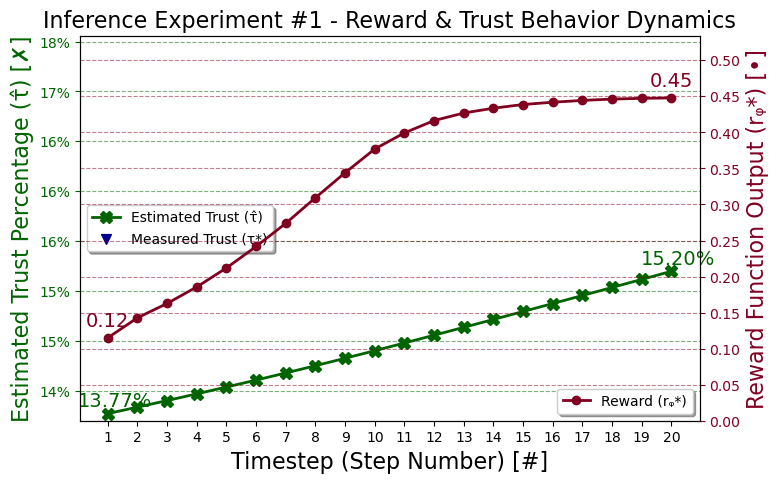

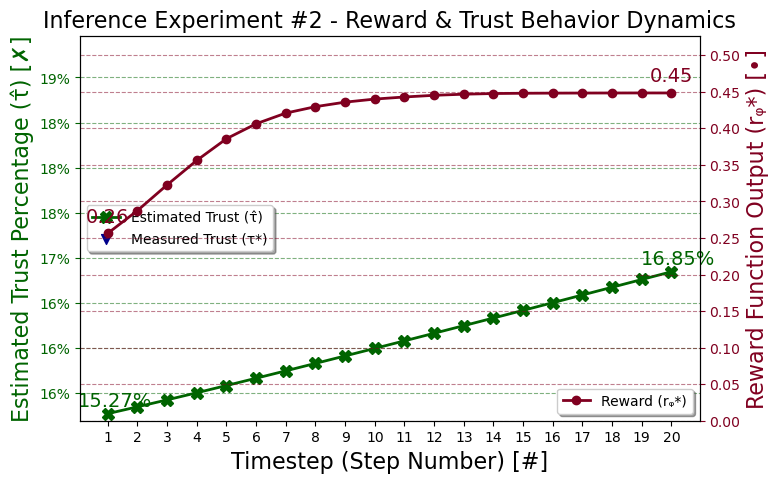

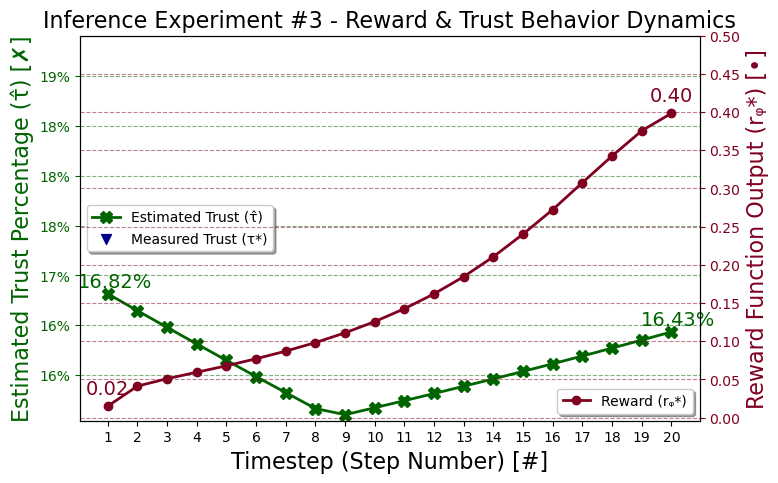

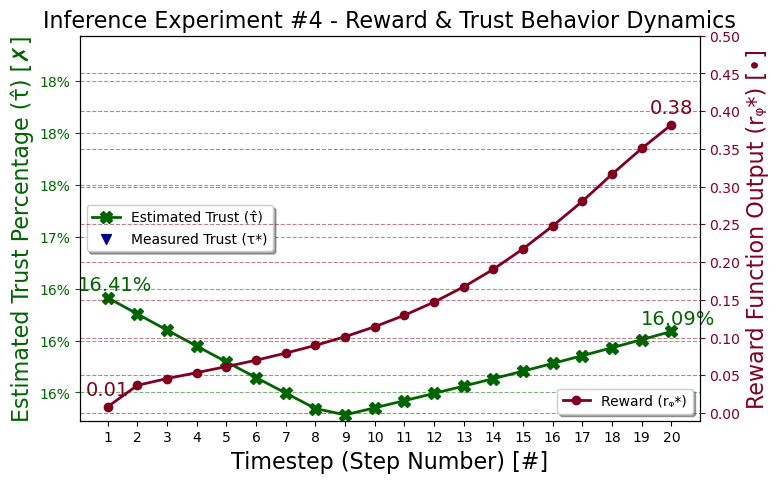

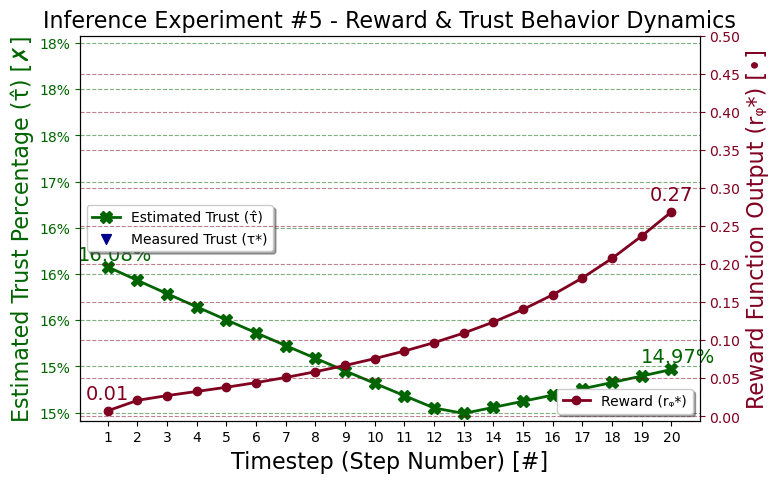

In [24]:
experiment_column = "Experiment"
timestep_column = "TimeStep"
reward_column = "Reward"
estimation_column = "TrustEstimation"
label_column = "TrustLabel"

for exp_number in range(1, inference_results_df[experiment_column].max() + 1):

    experiment_df = inference_results_df[inference_results_df[experiment_column] == exp_number]

    fig, ax1 = plt.subplots(1, 1,
                            figsize=(8, 5))

    trust_scatter = ax1.plot(experiment_df[timestep_column],
                             experiment_df[estimation_column],
                             color="#006400",
                             marker="X",
                             markersize=8,
                             linestyle="-",
                             linewidth=2,
                             label="Estimated Trust (τ̂)")

    ax1.set_title(f"Inference Experiment #{exp_number} - Reward & Trust Behavior Dynamics",
                  fontsize=16)
    ax1.set_xlabel("Timestep (Step Number) [#]",
                   fontsize=16)
    ax1.set_ylabel(f"Estimated Trust Percentage (τ̂) [\u2717]",
                   color="#006400",
                   fontsize=16)
    ax1.tick_params("y",
                    colors="#006400")

    reward_scatter = ax1.twinx()

    reward_scatter.plot(experiment_df[timestep_column],
                        experiment_df[reward_column],
                        color="#800020",
                        marker="o",
                        markersize=6,
                        linestyle="-",
                        linewidth=2,
                        label="Reward (rᵩ*)")

    reward_scatter.set_ylabel(f"Reward Function Output (rᵩ*) [•]",
                              color="#800020",
                              fontsize=16)
    reward_scatter.tick_params("y",
                               colors="#800020")

    ax1.set_ylim(ax1.get_ylim()[0],
                 ax1.get_ylim()[1] * 1.15)
    reward_scatter.set_ylim(reward_scatter.get_ylim()[0],
                 reward_scatter.get_ylim()[1] * 1.15)

    ax1.scatter(experiment_df[timestep_column].iloc[-1],
                experiment_df[label_column].iloc[-1],
                color="darkblue",
                marker="v",
                s=50,
                label="Measured Trust (τ*)")

    min_y = 0.0
    max_y = 0.5
    increment = 0.05
    reward_scatter.set_yticks(np.arange(min_y,
                                        max_y + increment,
                                        increment))
    def percent_formatter(x, pos):
        return f"{x*100:.0f}%"

    ax1.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

    ax1.set_xticks(np.arange(1,
                             len(experiment_df) + 1))
    ax1.grid(True,
             which="both",
             axis="y",
             linestyle="--",
             color="#006400",
             alpha=0.5)
    reward_scatter.grid(True,
                        which="both",
                        axis="y",
                        linestyle="--",
                        color="#800020",
                        alpha=0.5)

    first_trust = (experiment_df[timestep_column].iloc[0],
                   experiment_df[estimation_column].iloc[0])
    last_trust = (experiment_df[timestep_column].iloc[-1],
                  experiment_df[estimation_column].iloc[-1])
    ax1.annotate(f"{first_trust[1]*100:.2f}%",
                 first_trust,
                 textcoords="offset points",
                 xytext=(5, 5),
                 ha="center",
                 color="#006400",
                 fontsize=14)
    ax1.annotate(f"{last_trust[1]*100:.2f}%",
                 last_trust,
                 textcoords="offset points",
                 xytext=(5, 5),
                 ha="center",
                 color="#006400",
                 fontsize=14)
    ax1.annotate(f"{experiment_df[label_column].iloc[-1]*100:.0f}%",
                 (experiment_df[timestep_column].iloc[-1], experiment_df[label_column].iloc[-1]),
                 textcoords="offset points",
                 xytext=(5, 5),
                 ha="center",
                 color="darkblue",
                 fontsize=14)

    reward_scatter.text(experiment_df[timestep_column].iloc[0],
                        experiment_df[reward_column].iloc[0] + 0.01,
                        f"{experiment_df[reward_column].iloc[0]:.2f}",
                        color="#800020",
                        fontsize=14,
                        ha="center",
                        va="bottom")
    reward_scatter.text(experiment_df[timestep_column].iloc[-1],
                        experiment_df[reward_column].iloc[-1] + 0.01,
                        f"{experiment_df[reward_column].iloc[-1]:.2f}",
                        color="#800020",
                        fontsize=14,
                        ha="center",
                        va="bottom")

    # check visibility of the specific point in ax1
    # ax1.set_ylim(0.08, 0.25)

    ax1.legend(loc="center left", shadow=True, labels=["Estimated Trust (τ̂)", "Measured Trust (τ*)"])
    reward_scatter.legend(loc="lower right", shadow=True, labels=["Reward (rᵩ*)"])

    # plt.savefig(f"INFERENCE_experiment_{exp_number}_reward_trust_dynamics.png", dpi=600, bbox_inches="tight")

    plt.show()